In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import TargetEncoder # for dealing with high cardinal categories, for now use one-hot encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder # for dealing with ordinal categories
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR

from sklearn.metrics import mean_squared_error, r2_score
# data https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 1. Executive Summary/ Busienss Understanding

## Project Description from [Kaggle](www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation)
### Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

# 2. Data Understanding

## 2.1 Explore the numeric variables

Show some description information about the data

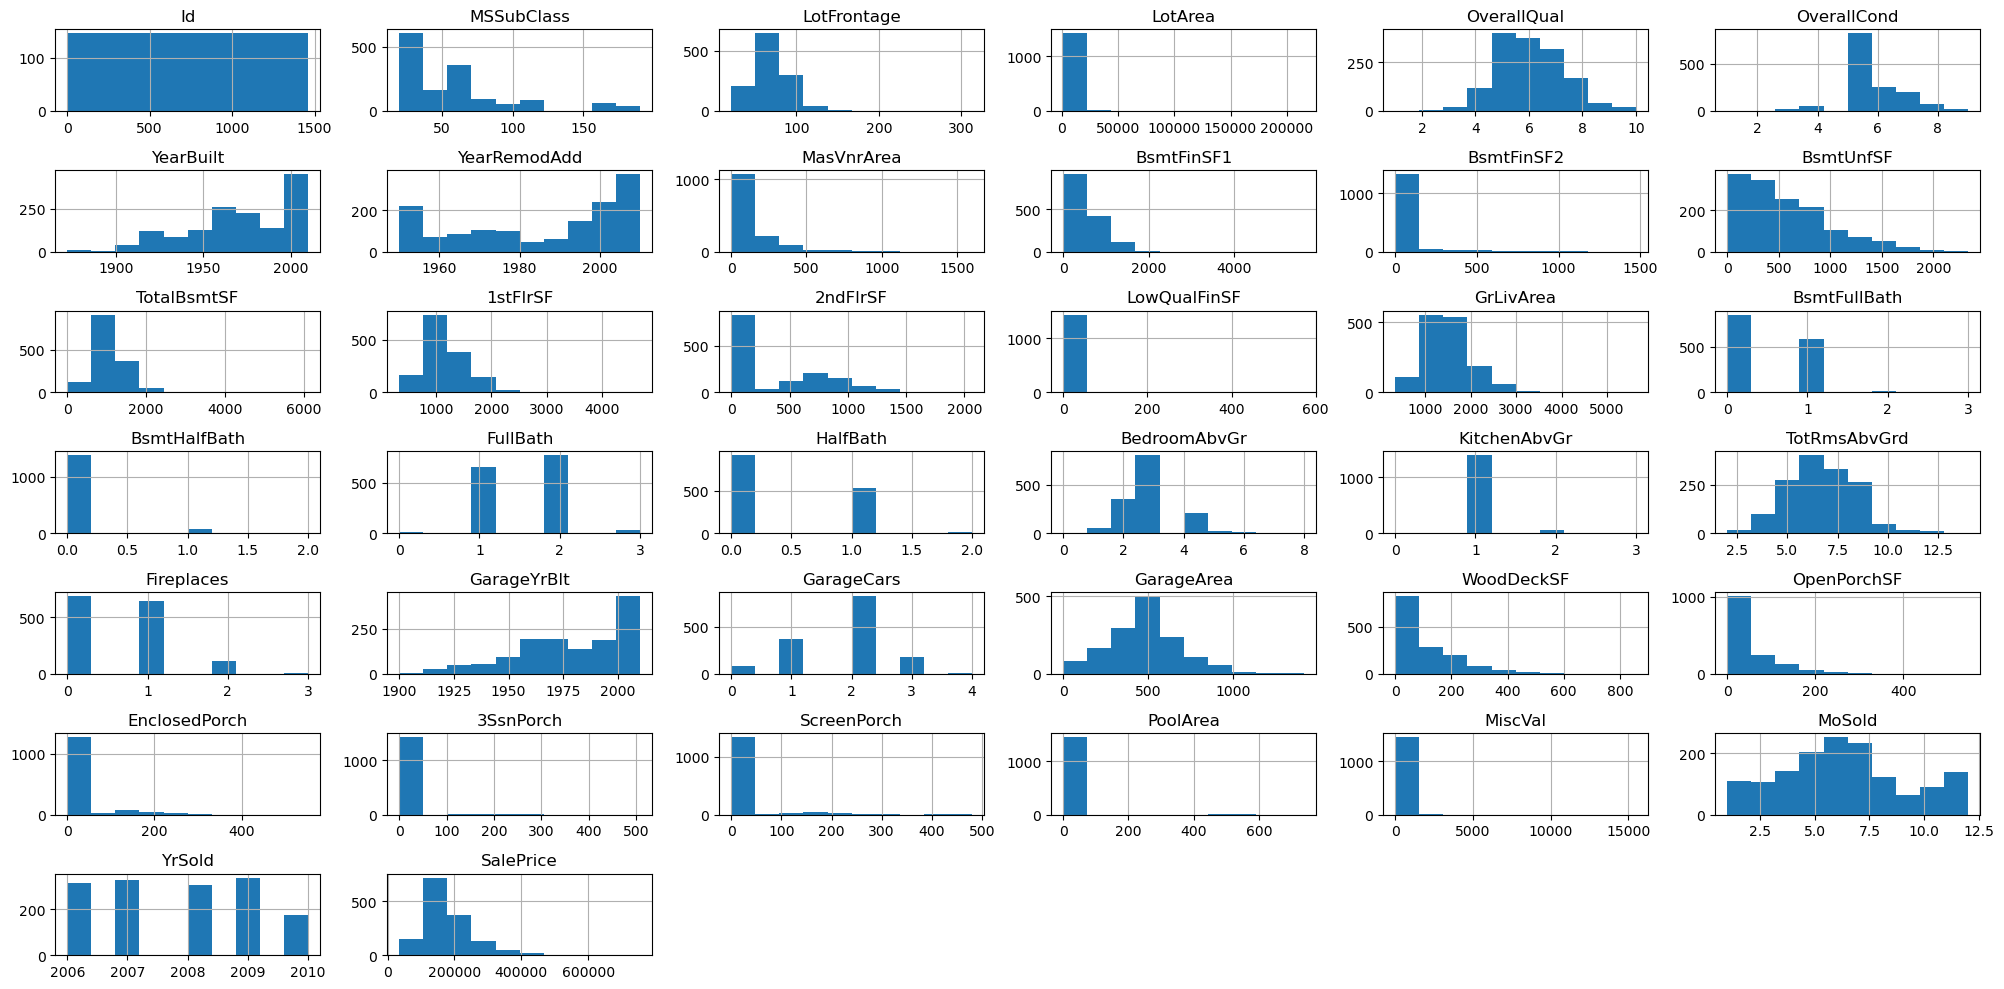

In [5]:
df.hist(figsize=(20, 10));
plt.tight_layout()

General Observations:
* Sales data roughly between 2006 and 2010.
* More houses sold in the summer months.
* Most houses between 1000 - 2000 square ft.
* Most houses built after 1950.

Take a look at the correlations of the numeric values vs. the sale price

In [6]:
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm', axis=None)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

General Observations:
* Sales price looks to be correlated with
    * OverallQual: Rates the overall material and finish of the house
    * GrLivArea: Above grade (ground) living area square feet
    * Other features related to square feet like GarageCars, GarageArea, Total basement sq ft, etc...
    

    
The above correlations make a lot of sense.  It might be useful to create some latent features with PCA to see if these features can be reduced and grouped into categories (ex. a square foot feature, a quality feature, etc...)

Check for outlier sale price

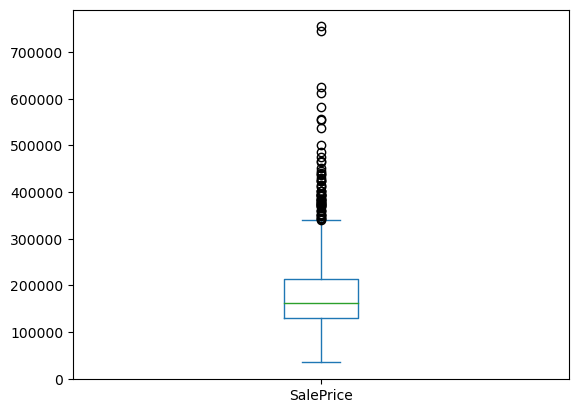

In [7]:
df.plot(y='SalePrice', kind='box');

There are two homes above 700K but that doesn't seem out of the norm for the housing market, so these will be left in.  

Create value for the log of the sale price and view the histogram.

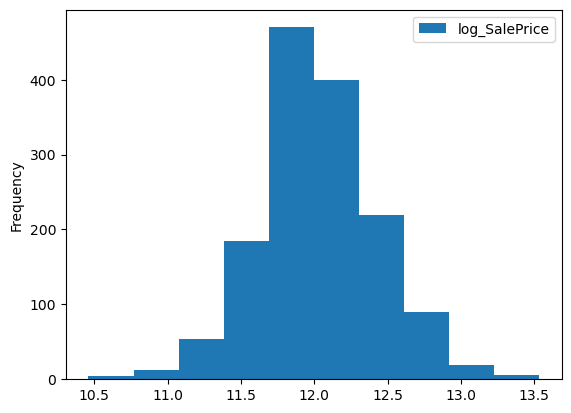

In [8]:
df['log_SalePrice'] = df['SalePrice'].apply('log')
df.plot(y='log_SalePrice', kind='hist');

Due to the skewed SalePrice distribution the log of the sale price will be the feature used for predicting.

## 2.2 Explore the categorical variables

In [9]:
non_numeric_cols = df.select_dtypes(exclude='number').columns

In [10]:
df_len =  df.shape[0]
for col in df[non_numeric_cols]:        
        # get info about top values
        names = list(df[col].value_counts().index)
        sliced_names = [str(name)[:25] for name in names]
        values = list(df[col].value_counts())
        print(f'{df[col].name}: {list(zip(sliced_names,values))}')

MSZoning: [('RL', 1151), ('RM', 218), ('FV', 65), ('RH', 16), ('C (all)', 10)]
Street: [('Pave', 1454), ('Grvl', 6)]
Alley: [('Grvl', 50), ('Pave', 41)]
LotShape: [('Reg', 925), ('IR1', 484), ('IR2', 41), ('IR3', 10)]
LandContour: [('Lvl', 1311), ('Bnk', 63), ('HLS', 50), ('Low', 36)]
Utilities: [('AllPub', 1459), ('NoSeWa', 1)]
LotConfig: [('Inside', 1052), ('Corner', 263), ('CulDSac', 94), ('FR2', 47), ('FR3', 4)]
LandSlope: [('Gtl', 1382), ('Mod', 65), ('Sev', 13)]
Neighborhood: [('NAmes', 225), ('CollgCr', 150), ('OldTown', 113), ('Edwards', 100), ('Somerst', 86), ('Gilbert', 79), ('NridgHt', 77), ('Sawyer', 74), ('NWAmes', 73), ('SawyerW', 59), ('BrkSide', 58), ('Crawfor', 51), ('Mitchel', 49), ('NoRidge', 41), ('Timber', 38), ('IDOTRR', 37), ('ClearCr', 28), ('StoneBr', 25), ('SWISU', 25), ('MeadowV', 17), ('Blmngtn', 17), ('BrDale', 16), ('Veenker', 11), ('NPkVill', 9), ('Blueste', 2)]
Condition1: [('Norm', 1260), ('Feedr', 81), ('Artery', 48), ('RRAn', 26), ('PosN', 19), ('RRAe

General Observations:
* It looks like some columns have high cardinality (Neighborhood, Exterior1st, Exterior2nd).  These may have to be dealt with later.
* Some features don't appear too informative (Street, Utilities)
* It looks like for many of the features the categories are very skewed to the top value (where the second highest value in a column is almost a factor of 10 lower than the top value)
* Some non-numeric featuers appear ordinal (like BsmtQual and BsmtCond), these could be re-encoded to numerical

Relationship with Target Variable

Nature of categorical data: If it's categorical, is it nominal (no natural order) or ordinal (has a natural order)?

# 3. Data Preparation

## 3.1 identify missing cols

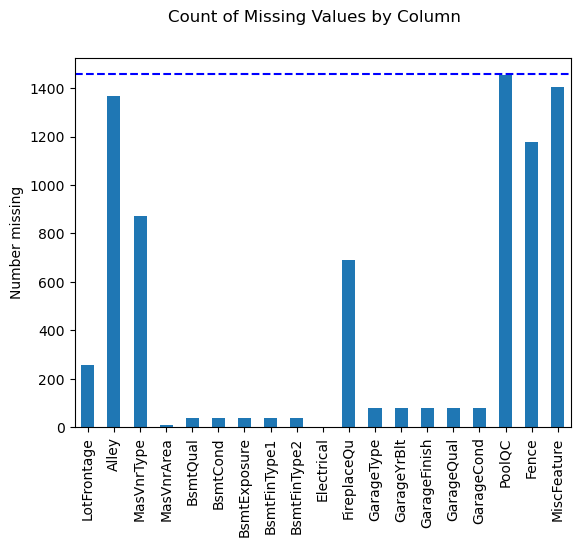

In [11]:
# identify and plot
missing_cols = df.columns[df.isna().any()].to_list()

fig, ax = plt.subplots()
df[missing_cols].isna().sum().plot.bar(ax=ax);
ax.set_ylabel('Number missing');
fig.suptitle('Count of Missing Values by Column');
plt.axhline(y = df.shape[0], color = 'b', linestyle = '--');

Drop columns missing more than 600 values

In [12]:
drop_cols = df.columns[df.isna().sum() > 600].to_list()
df.drop(columns=drop_cols, inplace=True)

## 3.2 Identify rows with many missing values

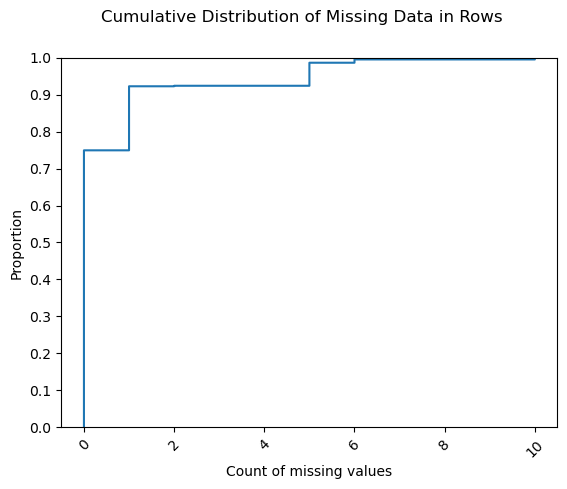

In [13]:
# identify and plot missing rows
missing_row = df.shape[1] - df.count(axis=1) # number of missing values per row

fig, ax = plt.subplots()
sns.ecdfplot(missing_row, ax=ax); 
plt.xticks(rotation=45);
ax.set_yticks(list(np.arange(0.0,1.1,0.1)));
plt.suptitle('Cumulative Distribution of Missing Data in Rows');
ax.set_xlabel('Count of missing values');

There are not many rows with lots of missing values.  Therefore these will be left as is and their values will be imputed.
The chart above shows that ~95% of rows are missings 5 or fewer values.

# 4. Modeling

Create a dataframe of the sale price (y) and the X matrix df

In [14]:
y = df[['SalePrice','log_SalePrice']]
X = df
X.drop(columns=['SalePrice', 'log_SalePrice'], inplace=True)

Build a prepocessor for the columns so that the missing values can be imputed and the ordinal columns can be converted to numeric

In [20]:
# later strip out ordinal features to encode those as numeric
numeric_features = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 
                    'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
                    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                     'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
                     'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                    'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

categorical_features = ['MSZoning', 'Street', 'LotShape', 'LandContour',
                        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                         'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                         'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                         'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
                         'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                         'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                         'KitchenQual', 'Functional', 'GarageType', 'GarageFinish',
                         'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
                         'SaleCondition']

# build the steps to occur on the numeric features
numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]
)

# build the steps for the categorical features
# use target encoder for categorical features due to higher cardinality of some categories plus there are not many observations so one-hot encoding would generate too many columns
categorical_transformer = Pipeline(
    #steps=[('encoder',OneHotEncoder(categories='auto', handle_unknown='ignore'))]
    steps=[('encoder',TargetEncoder(categories='auto', random_state=41))]
)

# build the tranformer to transform the columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

Build the classifier pipeline

In [21]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LinearSVR(random_state=41))
])

param = {
    'clf__C': (0.1, 1, 10),
    'clf__loss': ('epsilon_insensitive', 'squared_epsilon_insensitive')
}

gs_clf = GridSearchCV(clf, 
                     param, 
                     #scoring='neg_mean_squared_log_error',
                     scoring='r2',
                     error_score='raise')

Split the data and fit

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y['log_SalePrice'], test_size=0.25,random_state=41)

gs_clf.fit(X_train, y_train)

C:\git_repos\housing\envs\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\git_repos\housing\envs\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\git_repos\housing\envs\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\git_repos\housing\envs\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\git_repos\housing\envs\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\git_repos\housing\envs\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the n

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          '...
                                                                          'Exterior2nd',
                                                                          'ExterQual',
                                                                          'ExterCond',
                                                                          'Foundation',
                                                                          'BsmtQual',
                                                                          'BsmtCond',
                                                                          'BsmtExposure',
                                                                          'BsmtFinType1',
                                                                          'BsmtFinType2',
                                                                          'Heating',
                                                                          'HeatingQC',
                                                                          'CentralAir',
                                                                          'Electrical',
                                                                          'KitchenQual',
                                                                          'Functional', ...])])),
                                       ('clf', LinearSVR(random_state=41))]),
             param_grid={'clf__C': (0.1, 1, 10),
                         'clf__loss': ('epsilon_insensitive',
                                       'squared_epsilon_insensitive')},
             scoring='r2')

compute the accuracy

In [23]:
pd.DataFrame(gs_clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.185538,0.016834,0.013623,0.004258,0.1,epsilon_insensitive,"{'clf__C': 0.1, 'clf__loss': 'epsilon_insensit...",0.805192,0.912719,0.644943,0.917530,0.819216,0.819920,0.098969,3
1,0.159130,0.010360,0.011602,0.003262,0.1,squared_epsilon_insensitive,"{'clf__C': 0.1, 'clf__loss': 'squared_epsilon_...",0.830681,0.883068,0.739416,0.891343,0.922074,0.853316,0.064100,1
2,0.148169,0.009668,0.009813,0.002155,1,epsilon_insensitive,"{'clf__C': 1, 'clf__loss': 'epsilon_insensitive'}",0.746381,0.852547,0.728171,0.855604,0.906348,0.817810,0.068718,5
3,0.190405,0.025901,0.013602,0.005040,1,squared_epsilon_insensitive,"{'clf__C': 1, 'clf__loss': 'squared_epsilon_in...",0.763149,0.859314,0.730436,0.862174,0.909841,0.824983,0.067120,2
4,0.151946,0.003988,0.011015,0.004026,10,epsilon_insensitive,"{'clf__C': 10, 'clf__loss': 'epsilon_insensiti...",0.746381,0.852547,0.728171,0.855604,0.906348,0.817810,0.068718,5
5,0.151435,0.008981,0.008599,0.001021,10,squared_epsilon_insensitive,"{'clf__C': 10, 'clf__loss': 'squared_epsilon_i...",0.748200,0.853289,0.728416,0.856310,0.906731,0.818589,0.068530,4


In [24]:
print(r2_score(y_train, gs_clf.predict(X_train)))

0.879509627754587


# 5. Evaluation